In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

%matplotlib inline

In [4]:
# Loading  data
df = pd.read_csv('UCI_Credit_Card_balanced.csv')

# Data Preparation

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [7]:
scaler = StandardScaler()

In [8]:
scaler.fit(df.drop('Y',axis=1))

StandardScaler()

In [9]:
scaled_features = scaler.fit_transform(df.drop('Y',axis=1))

Splitting labels and features

In [10]:
X = pd.DataFrame(scaled_features,columns=df.columns[:-1]).values
y = df['Y'].values

In [11]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.05, random_state=69)

In [12]:
x, z = df['Y'].value_counts()
print("Data Split: " + str(int(x/(x+z)*100)) + ":" + str(int(z/(x+z)*100)))

Data Split: 52:47


# Setting Up and Training The Model

In [13]:
from xgboost import XGBClassifier

In [14]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', silent=True, nthread=1)

# Gridsearch 

In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
# define search space
param_grid = dict()
param_grid['min_child_weight'] = [1, 5, 10]
param_grid['gamma'] = [0.5, 1, 1.5, 2, 5]
param_grid['subsample'] = [0.6, 0.8, 1.0]
param_grid['colsample_bytree'] = [0.6, 0.8, 1.0]
param_grid['max_depth'] = [3, 4, 5]

In [18]:
# define search
grid = GridSearchCV(xgb, param_grid, scoring='accuracy', n_jobs=-1, cv=5)

In [19]:
t0 = datetime.now()
grid_results = grid.fit(X, y)
t1 = datetime.now()

[01:39:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [20]:
# summarize results
print("Best: %f using %s" % (grid_results.best_score_, grid_results.best_params_))
print("Execution Time: ", (t1 - t0))

Best: 0.763056 using {'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.6}
Execution Time:  3:31:27.095452


# Crossvalidate Best Model

In [21]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate

In [22]:
min_child_weight = grid_results.best_params_['min_child_weight']
gamma = grid_results.best_params_['gamma']
subsample = grid_results.best_params_['subsample']
colsample_bytree = grid_results.best_params_['colsample_bytree']
max_depth = grid_results.best_params_['max_depth']

In [24]:
xgb_best = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', nthread=1,
                    min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree, max_depth=max_depth)                

In [25]:
t0 = datetime.now()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=69)
scores = cross_validate(xgb_best, X, y, scoring=['accuracy','roc_auc','precision','recall','f1'], cv=cv, n_jobs=-1)
t1 = datetime.now()

In [54]:
print('Mean ROC AUC: %.2f%% Std Dev: (+/- %.3f%%)' % (np.mean(scores['test_accuracy']*100), np.std(scores['test_accuracy']*100)))
print('Mean ROC AUC: %.2f%% Std Dev: (+/- %.3f%%)' % (np.mean(scores['test_roc_auc']*100), np.std(scores['test_roc_auc']*100)))
print('Mean Precision: %.2f%% Std Dev: (+/- %.3f%%)' % (np.mean(scores['test_precision']*100), np.std(scores['test_precision']*100)))
print('Mean Recall: %.2f%% Std Dev: (+/- %.3f%%)' % (np.mean(scores['test_recall']*100), np.std(scores['test_recall']*100)))
print('Mean F1 Score: %.2f%% Std Dev: (+/- %.3f%%)' % (np.mean(scores['test_f1']*100), np.std(scores['test_f1']*100)))
print("Execution Time: ", (t1 - t0))

Mean ROC AUC: 76.35% Std Dev: (+/- 0.843%)
Mean ROC AUC: 84.08% Std Dev: (+/- 0.681%)
Mean Precision: 78.18% Std Dev: (+/- 0.916%)
Mean Recall: 69.73% Std Dev: (+/- 1.263%)
Mean F1 Score: 73.71% Std Dev: (+/- 1.019%)
Execution Time:  0:04:08.768781


### Final Evaluations

In [31]:
from sklearn.metrics import plot_confusion_matrix, cohen_kappa_score, plot_roc_curve, classification_report
import pickle
import shap

In [30]:
t0 = datetime.now()
xgb_best.fit(X,y)
t1 = datetime.now()
print("Training Time: ", (t1 - t0))

[09:10:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              silent=True, subsample=0.6, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [9]:
print("Training Time: ", (t1 - t0))

Training Time:  0:04:08.768781


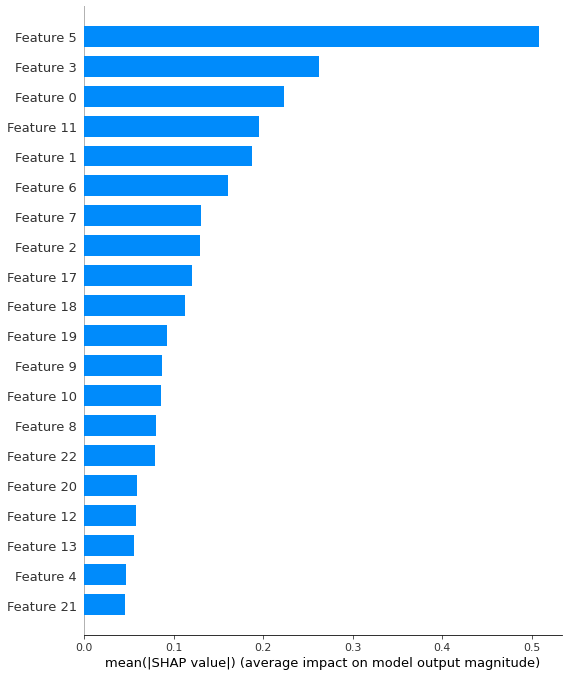

In [3]:
shap_values = shap.TreeExplainer(xgb_best).shap_values(X)

plt.figure(figsize=(7, 5))
ax = shap.summary_plot(shap_values, X, plot_type="bar", show=False)

plt.tight_layout()
plt.savefig(r'C:\Users\alanw\OneDrive\Varsity\Research\Paper Itself\LaTeX\images\xgb_shap.png')
plt.show()


In [4]:
predictions = xgb_best.predict(X_test)

<Figure size 504x360 with 0 Axes>

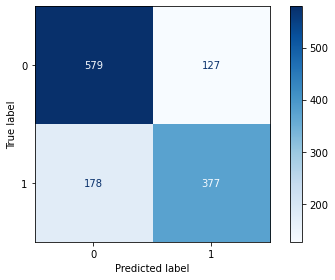

In [8]:
plt.figure(figsize=(7, 5))
ax = plot_confusion_matrix(xgb_best,X_test,y_test,cmap=plt.cm.Blues)

plt.tight_layout()
plt.savefig(r'C:\Users\alanw\OneDrive\Varsity\Research\Paper Itself\LaTeX\images\xgb_conf.png')
plt.show()

<Figure size 504x360 with 0 Axes>

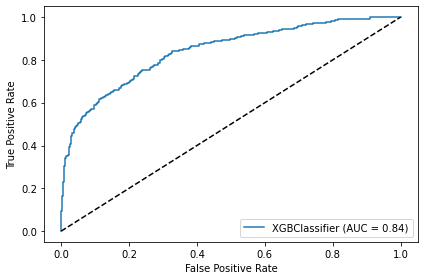

In [7]:
plt.figure(figsize=(7, 5))
ax = plot_roc_curve(xgb_best,X_test,y_test)
x = np.linspace(0, 1, 100)
ax = plt.plot(x, x, linestyle='--',color='black')

plt.tight_layout()
plt.savefig(r'C:\Users\alanw\OneDrive\Varsity\Research\Paper Itself\LaTeX\images\xgb_roc.png')
plt.show()

In [38]:
kappa = cohen_kappa_score(y_test, predictions)
print("Cohen's Kappa: %.2f" % (kappa))

Cohen's Kappa: 0.50


In [46]:
import pickle

In [47]:
Pkl_Filename = "XGBoost_Final.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(xgb_best, file)

In [10]:
import dill
dill.dump_session('xgb_final.db')

In [2]:
import dill
dill.load_session(r'C:\Users\alanw\OneDrive\Varsity\Research\Code\xgb_final.db')